In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.random as jr
import kkr
import os, datetime
import matplotlib.pyplot as plt

2023-11-17 12:05:37.789391: W external/xla/xla/service/gpu/nvptx_compiler.cc:702] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
DT = 0.2
STEPS = 100
N_TRAIN = 75
N_TEST = 20

D = 1000
params_base_kernel = {"name": "square-exponential", "p_kernel":{"scale":0.2}}

DEVICES = jax.devices("gpu")
LOAD_DATA = 0 # 
PRNGKey = jr.PRNGKey(44)
save_path = os.path.join("results", "cubic_limit_cycle"+"_" +datetime.datetime.today().strftime('%Y-%m-%d'))

In [4]:
__name__

'__main__'

In [5]:
def generate_data(N, STEPS, PRNGKey):
    dynamical_system = kkr.auxilliary.make_2d_cubic_limit_cycle(*kkr.auxilliary.params_2d_cubic_limit_cycle)
    initial_conditions = kkr.auxilliary.sample_box(N, PRNGKey=PRNGKey)[0]
    return kkr.auxilliary.get_gamma_ivp(STEPS, initial_conditions, dynamical_system, DT)
def generate_eigenvalues_dt(D, PRNGKey=jax.random.PRNGKey(0)):
    return kkr.auxilliary.convert_2d_to_complex(kkr.auxilliary.sample_disk(D, random=True, PRNGKey=PRNGKey)[0])

In [6]:
os.makedirs(save_path, exist_ok=True)

if LOAD_DATA:
    data_load = kkr.auxilliary.load_trajectory_dict(os.path.join(save_path, "data.npz"))
    data_train = data_load["train"]
    data_test = data_load["test"]
else:
    PRNGKey, subkey = jr.split(PRNGKey)
    data = generate_data(N_TRAIN + N_TEST, STEPS, subkey)
    data_train = data.select_N([i for i in range(N_TRAIN)])
    data_test = data.select_N([i for i in range(N_TRAIN, N_TRAIN+N_TEST)])
    kkr.auxilliary.save_trajectory_dict(os.path.join(save_path, "data"), train=data_train, test=data_test)

In [7]:
from sklearn.preprocessing import MinMaxScaler
PRNGKey, subkey = jr.split(PRNGKey)
KKR_model = kkr.model.kkr_estimator.KoopmanKernelDTRegressor(
    eigenvalues=generate_eigenvalues_dt(D, subkey), 
    preprocessor=MinMaxScaler((-1, 1)),
    kernel_name=params_base_kernel["name"], 
    kernel_params=params_base_kernel["p_kernel"], 
    timestep=DT,
    device=DEVICES[0],
    regularizer_invariant=1e-10,
    regularizer_isometric=1e-8
    )

In [8]:
KKR_model.fit(data_train, data_train)
KKR_model.save(os.path.join(save_path, "KKR_model.pkl"))

In [9]:
prediction_train = KKR_model.predict(data_train.X[:, 0, :], STEPS)
prediction_test = KKR_model.predict(data_test.X[:, 0, :], STEPS)

mean train loss: 0.016027917220161635
mean test loss:	 0.16521216632675526


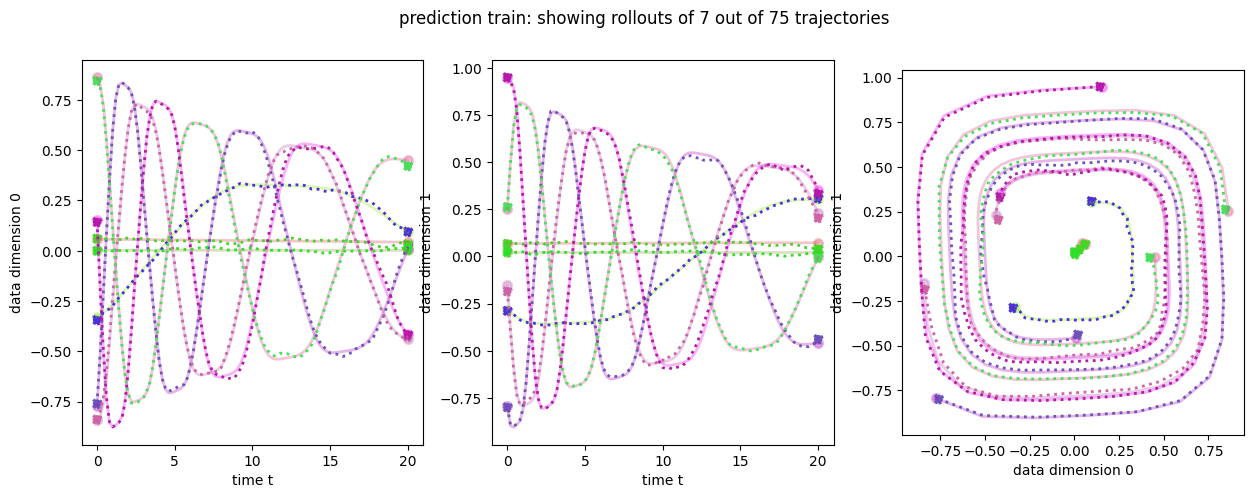

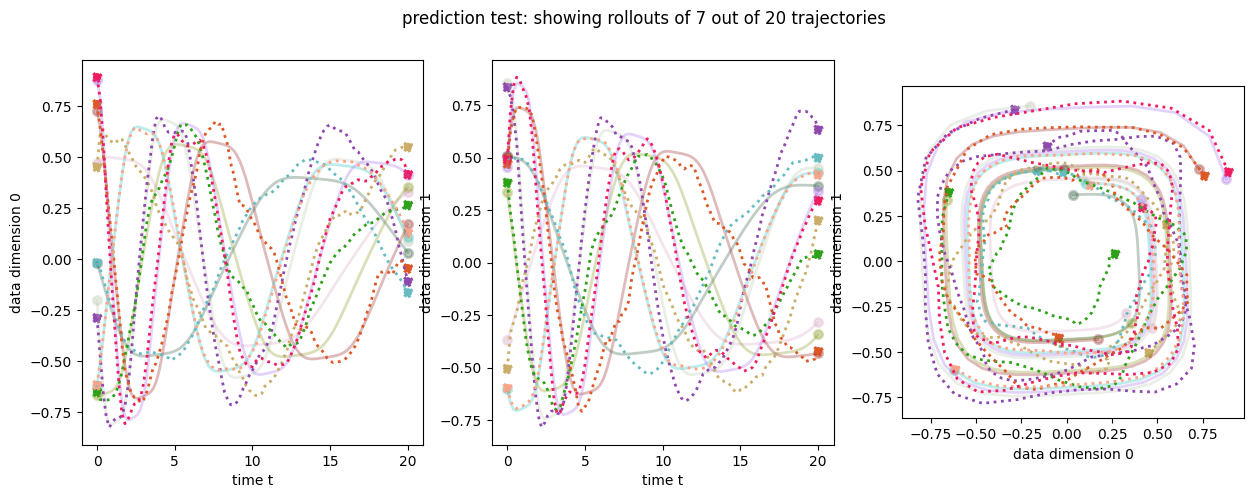

In [11]:
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TRAIN, [min(7, N_TRAIN)], replace=0)
f, _ = kkr.auxilliary.plot_data( data_train, i_plot=i_plot, prepend_tag="data train", plt_params={"alpha":0.3,});
kkr.auxilliary.plot_data( prediction_train, i_plot=i_plot, prepend_tag="prediction train", fig=f,plt_params={"linestyle":"dotted",});
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TEST, [min(7, N_TEST)],  replace=0)
f, _ = kkr.auxilliary.plot_data( data_test, i_plot=i_plot, prepend_tag="data test", plt_params={"alpha":0.3,});
kkr.auxilliary.plot_data( prediction_test, i_plot=i_plot, prepend_tag="prediction test", fig=f, plt_params={"linestyle":"dotted"});
print("mean train loss: {}\nmean test loss:\t {}".format(
    kkr.auxilliary.p_norm((data_train - prediction_train).X, a=[0, 1, 2], p=2),
    kkr.auxilliary.p_norm((data_test  - prediction_test).X,  a=[0, 1, 2], p=2)))